# Coursera - Capstone Project for IBM Data Science Certificate
"The battle of the neighborhoods" by Nandini Gupta

This is the final assignment the Coursera Capstone Project

Objective: Explore the best neighborhood in Brooklyn NY for opening a new restaurant . 
Choices to be explored are Location & type of Restaurant - Indian or Italian

Data Sources:  'newyork_data.json' https://cocl.us/new_york_dataset

## Table of Content

#### SOLUTION DESIGN & APPROACH
##### Solution is approached in the following steps as listed below 
###### Step 1 - Create initial dataframe NYneighborhoods with 5 Borouhs across 306 neighborhoods. 
###### Step2 - Narrow down pointer to One of the Boroughs Brooklyn & its 70 Neighbourhoods - Mapping those Neighbourhoods on a map.
###### Step 3 - EXPLORING the NEIGHBOURHOODS of BROOKLYN USING FOURSQUARE APIS.
###### Step 4 - Venue clustering by neighborhood and analysis of 'best' fit for new location.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 102kB 11.5MB/s ta 0:00:01
Libraries imported.


##### STEP 1 - Create initial dataframe NYneighborhoods with 5 Borouhs across 306 neighborhoo


In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
NYneighbor_data = newyork_data['features']
NYneighbor_data[0]    

Data downloaded!


{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [3]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NYneighborhoods = pd.DataFrame(columns=column_names)
NYneighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [4]:
for data in NYneighbor_data:
    borough = data["properties"]["borough"]
    neighborhood = data["properties"]["name"]
    neigh_latitude = data["geometry"]["coordinates"][1]
    neigh_longitude = data["geometry"]["coordinates"][0]
    
    NYneighborhoods = NYneighborhoods.append({"Borough" : borough ,
                                             "Neighborhood" : neighborhood ,
                                             "Latitude" : neigh_latitude ,
                                             "Longitude" : neigh_longitude} , ignore_index=True)
    
NYneighborhoods.head()
    

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
print(" NYC_data dataframe has {} borough and {} Neighbourhoods".format(len(NYneighborhoods['Borough'].unique())
                                                              ,NYneighborhoods.shape[0]))

 NYC_data dataframe has 5 borough and 306 Neighbourhoods


##### Step2 - Narrow down pointer to One of the Boroughs Brooklyn & its 70 Neighbourhoods - Mapping those Neighbourhoods on a map

In [6]:
brooklyn_data = NYneighborhoods[NYneighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
print(" brooklyn_data dataframe has {} borough and {} Neighbourhoods".format(len(brooklyn_data['Borough'].unique())
                                                              ,brooklyn_data.shape[0]))

brooklyn_data.head()

 brooklyn_data dataframe has 1 borough and 70 Neighbourhoods


,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [7]:
address = "Brooklyn , NY"

geolocator = Nominatim(user_agent = "brooklyn_explorer")
location = geolocator.geocode(address)
brook_latitude = location.latitude
brook_longitude = location.longitude

print("Geo coordinates of {} are {} , {}".format(location , brook_latitude , brook_longitude ))

Geo coordinates of Brooklyn, New York, Kings County, New York, United States of America are 40.6501038 , -73.9495823


##### plotting map of brooklyn along with all neighbors

In [8]:
map_brooklyn = folium.Map(location = [brook_latitude ,brook_longitude ] , zoom_start = 11)

#Add markers 
for lat , long , label in zip(brooklyn_data['Latitude'] ,brooklyn_data['Longitude'] , brooklyn_data['Neighborhood']):
    label = folium.Popup(label , parse_html = True)
    folium.CircleMarker(
    [lat,long],
    radius = 7,
    popup = label,
    color = 'blue',
    fill = True,
    fill_color = "#31cc9b",
    fill_opacity = 0.7 
    ).add_to(map_brooklyn)

    
map_brooklyn


##### Step 3 - EXPLORING the NEIGHBOURHOODS of BROOKLYN USING FOURSQUARE APIS.

In [9]:
Client_Id = "AWURO2ERQB1DYQC05GDKOJQWASJ1C5O4F0ZMVEPGF4XGPR4C"
Client_Secret = "XXELD43ZJF1E1543GLT0BO3OSYR1QXBRAHP45YUGR0ZX22EX"
Version = "20180605" 

In [10]:
brooklyn_data.loc[0 , 'Neighborhood']

'Bay Ridge'

Here we are going to explore all venues of "Bay Ridge" using Forsquare location API

In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    Client_Id, 
    Client_Secret, 
    Version, 
    brooklyn_data.loc[0 , 'Latitude'], #Bay Ridge exist at first position of dataframe
    brooklyn_data.loc[0 , 'Longitude'],
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=AWURO2ERQB1DYQC05GDKOJQWASJ1C5O4F0ZMVEPGF4XGPR4C&client_secret=XXELD43ZJF1E1543GLT0BO3OSYR1QXBRAHP45YUGR0ZX22EX&v=20180605&ll=40.625801065010656,-74.03062069353813&radius=500&limit=100'

In [12]:
bay_ridge_venue_data = requests.get(url).json()
bay_ridge_venue_data

{'meta': {'code': 200, 'requestId': '5ece36dcb57e88001be28f5f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Bay Ridge',
  'headerFullLocation': 'Bay Ridge, Brooklyn',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 81,
  'suggestedBounds': {'ne': {'lat': 40.63030106951066,
    'lng': -74.02470273356597},
   'sw': {'lat': 40.62130106051065, 'lng': -74.03653865351028}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b895827f964a5206c2d32e3',
       'name': 'Pilo Arts Day Spa and Salon',
       'location': {'address': '8412 3rd Ave',
        'lat': 40.62474788273414,
        'lng': -74.03059056940135,
        'labeledLatLngs': [{'label': 'display',
          'lat':

Here we have extracted essential venues details for "Bay Ridge"

In [13]:
venues = bay_ridge_venue_data["response"]["groups"][0]["items"]
venues = json_normalize(venues)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
bay_ridge_venues = venues.loc[:, filtered_columns]

#creating function to filter out category name
def get_category_name(row):
    try:
        category_list = row["venue.categories"]
    except:
        category_list = row["categories"]
    
    if len(category_list) == 0:
        return None
    else:
        return category_list[0]["name"]
    
#filter category name 
bay_ridge_venues['venue.categories'] =   bay_ridge_venues.apply(get_category_name , axis = 1)

bay_ridge_venues.columns = [col.split(".")[-1] for col in bay_ridge_venues.columns ]
bay_ridge_venues.insert(0 , 'neighborhood','Bay Ridge')

print("Total no of venues in Bay Ridge are {}".format(bay_ridge_venues.shape[0]))
bay_ridge_venues.head()


Total no of venues in Bay Ridge are 81


,neighborhood,name,categories,lat,lng
0,Bay Ridge,Pilo Arts Day Spa and Salon,Spa,40.624748,-74.030591
1,Bay Ridge,Bagel Boy,Bagel Shop,40.627896,-74.029335
2,Bay Ridge,Leo's Casa Calamari,Pizza Place,40.624200,-74.030931
3,Bay Ridge,Pegasus Cafe,Breakfast Spot,40.623168,-74.031186
4,Bay Ridge,The Bookmark Shoppe,Bookstore,40.624577,-74.030562


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            Client_Id, 
            Client_Secret, 
            Version, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [16]:
print("Total venues of brooklyn are {}".format(brooklyn_venues.shape[0]))

Total venues of brooklyn are 2733


In [17]:
brooklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,The Bookmark Shoppe,40.624577,-74.030562,Bookstore


In [18]:
brooklyn_venues_100 = brooklyn_venues.groupby('Neighborhood').count()
brooklyn_venues_100 = brooklyn_venues_100.loc[brooklyn_venues_100['Venue']==100].reset_index()
brooklyn_venues = brooklyn_venues.loc[brooklyn_venues["Neighborhood"].isin(brooklyn_venues_100["Neighborhood"])]
brooklyn_venues_100



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Brooklyn Heights,100,100,100,100,100,100
1,Carroll Gardens,100,100,100,100,100,100
2,Downtown,100,100,100,100,100,100
3,Greenpoint,100,100,100,100,100,100
4,North Side,100,100,100,100,100,100
5,South Side,100,100,100,100,100,100


In [19]:
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))
brooklyn_venues.reset_index(drop = True)


There are 166 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Greenpoint,40.730201,-73.954241,Karczma,40.730102,-73.955092,Polish Restaurant
1,Greenpoint,40.730201,-73.954241,goodyoga,40.730010,-73.956167,Yoga Studio
2,Greenpoint,40.730201,-73.954241,Chiko,40.731871,-73.954369,Sushi Restaurant
3,Greenpoint,40.730201,-73.954241,Early,40.732069,-73.954721,Café
4,Greenpoint,40.730201,-73.954241,Sunshine Laundry & Pinball Emporium,40.729318,-73.953564,Laundry Service
5,Greenpoint,40.730201,-73.954241,Temkin’s,40.730389,-73.953554,Bar
6,Greenpoint,40.730201,-73.954241,Oxomoco,40.729981,-73.955460,Mexican Restaurant
7,Greenpoint,40.730201,-73.954241,Friducha,40.731512,-73.954281,Mexican Restaurant
8,Greenpoint,40.730201,-73.954241,IncrediPole,40.731838,-73.955069,Gymnastics Gym
9,Greenpoint,40.730201,-73.954241,Cafe Riviera,40.728514,-73.953477,Café


In [20]:
brooklyn_venues['Count'] = 1
brooklyn_venues_Restaurant =  brooklyn_venues[brooklyn_venues['Venue Category'].str.contains("Restaurant")].reset_index(drop = True)
brooklyn_venues_Restaurant["Venue Type"] = "Restaurant"
brooklyn_venues_hotel =  brooklyn_venues[brooklyn_venues['Venue Category'].str.contains("Hotel")].reset_index(drop = True)
brooklyn_venues_hotel["Venue Type"] = "Hotel"


brooklyn_venues_final = pd.concat([brooklyn_venues_Restaurant , brooklyn_venues_hotel]).reset_index(drop = True)
brooklyn_venues_final = brooklyn_venues_final.drop(["Neighborhood Latitude", "Neighborhood Longitude","Venue Latitude","Venue Longitude"], axis = 1)
brooklyn_venues_final.groupby('Neighborhood').count()


,Venue,Venue Category,Count,Venue Type
Neighborhood,,,,
Brooklyn Heights,21,21,21,21
Carroll Gardens,22,22,22,22
Downtown,25,25,25,25
Greenpoint,21,21,21,21
North Side,25,25,25,25
South Side,30,30,30,30


In [21]:
brooklyn_venues_final.head(10)

,Neighborhood,Venue,Venue Category,Count,Venue Type
0,Greenpoint,Karczma,Polish Restaurant,1,Restaurant
1,Greenpoint,Chiko,Sushi Restaurant,1,Restaurant
2,Greenpoint,Oxomoco,Mexican Restaurant,1,Restaurant
3,Greenpoint,Friducha,Mexican Restaurant,1,Restaurant
4,Greenpoint,Citroën,French Restaurant,1,Restaurant
5,Greenpoint,Archestratus Books & Foods,Restaurant,1,Restaurant
6,Greenpoint,Đi ăn Đi,Vietnamese Restaurant,1,Restaurant
7,Greenpoint,Esme,New American Restaurant,1,Restaurant
8,Greenpoint,Sakura 6,Sushi Restaurant,1,Restaurant
9,Greenpoint,Le Gamin,French Restaurant,1,Restaurant


### Expanding the Visualization of Restaurants across those 7 Neighborhoods through WORDCLOUD

In [22]:
!pip install wordcloud
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS
print ('Wordcloud is installed and imported!')
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

     |████████████████████████████████| 368kB 7.7MB/s eta 0:00:01
Wordcloud is installed and imported!


In [23]:
word_cloud_df = brooklyn_venues_final.groupby('Neighborhood')["Venue Category"].apply(lambda x : ','.join(set(x.dropna()))).reset_index()
word_cloud_df

,Neighborhood,Venue Category
0,Brooklyn Heights,"Asian Restaurant,Vietnamese Restaurant,Chinese..."
1,Carroll Gardens,"Filipino Restaurant,Greek Restaurant,Spanish R..."
2,Downtown,"Vegetarian / Vegan Restaurant,French Restauran..."
3,Greenpoint,"Chinese Restaurant,American Restaurant,Mexican..."
4,North Side,"Asian Restaurant,Seafood Restaurant,American R..."
5,South Side,"Korean Restaurant,Vegetarian / Vegan Restauran..."


Asian Restaurant,Vietnamese Restaurant,Chinese Restaurant,American Restaurant,Mexican Restaurant,Thai Restaurant,Middle Eastern Restaurant,Italian Restaurant,Ramen Restaurant,Falafel Restaurant,Sushi Restaurant,Japanese Restaurant,Indian Restaurant,New American Restaurant

--------- Analyziing Brooklyn Heights Neighborhood ---------




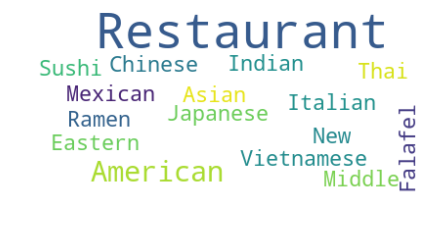

Filipino Restaurant,Greek Restaurant,Spanish Restaurant,Thai Restaurant,Dumpling Restaurant,Latin American Restaurant,French Restaurant,Sushi Restaurant,Italian Restaurant,Restaurant

--------- Analyziing Carroll Gardens Neighborhood ----------




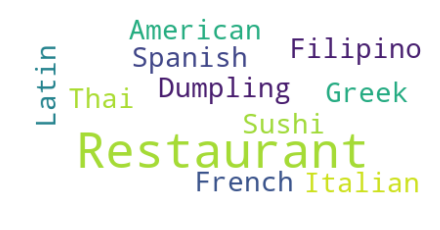

Vegetarian / Vegan Restaurant,French Restaurant,Polish Restaurant,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,South American Restaurant,Pakistani Restaurant,Peruvian Restaurant,Mexican Restaurant,Spanish Restaurant,Thai Restaurant,Dumpling Restaurant,Italian Restaurant,Hawaiian Restaurant,American Restaurant,Shanghai Restaurant,Mediterranean Restaurant

------------- Analyziing Downtown Neighborhood -------------




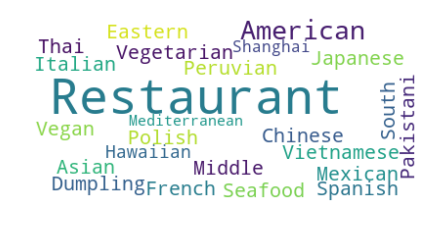

Chinese Restaurant,American Restaurant,Mexican Restaurant,Hotel,Thai Restaurant,Italian Restaurant,Polish Restaurant,French Restaurant,Sushi Restaurant,Vietnamese Restaurant,Indian Restaurant,New American Restaurant,Restaurant

------------ Analyziing Greenpoint Neighborhood ------------




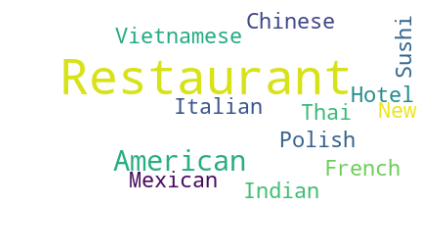

Asian Restaurant,Seafood Restaurant,American Restaurant,Arepa Restaurant,Mexican Restaurant,Hotel,Thai Restaurant,Argentinian Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Southern / Soul Food Restaurant,French Restaurant,Falafel Restaurant,Chinese Restaurant,Japanese Restaurant,Indian Restaurant,South American Restaurant

------------ Analyziing North Side Neighborhood ------------




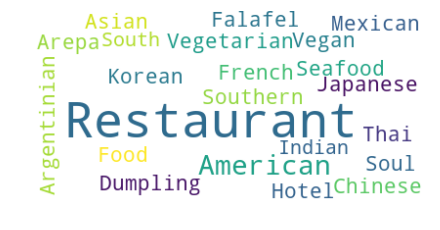

Korean Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Sushi Restaurant,Japanese Restaurant,Indian Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Tapas Restaurant,South American Restaurant,Greek Restaurant,Mexican Restaurant,Thai Restaurant,Italian Restaurant,New American Restaurant,Restaurant,American Restaurant,Latin American Restaurant,Arepa Restaurant,Mediterranean Restaurant

------------ Analyziing South Side Neighborhood ------------




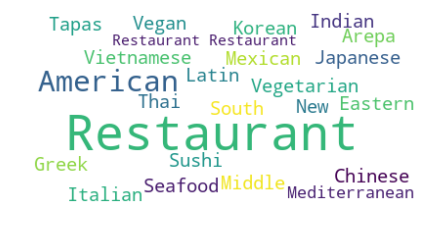

In [24]:
stop_words = set(STOPWORDS)

class color:
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

for i,j1 in word_cloud_df.iterrows(): 
        word_string_Heading = word_cloud_df['Neighborhood'][i]
        word_string = word_cloud_df['Venue Category'][i]
        print(word_string)
        wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords=stop_words,background_color='white').generate(word_string)
        print("\n"+ color.RED + " Analyziing {} Neighborhood ".format(word_string_Heading).center(60,"-") + color.END + "\n\n")
        # display the cloud
        fig = plt.figure()
        fig.set_figwidth(7)
        fig.set_figheight(9)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()


In [25]:
pivot = pd.pivot_table(brooklyn_venues_final,index=["Neighborhood","Venue Type"], values=["Count"],aggfunc=np.sum)
pivot

Count
Neighborhood     Venue Type       
Brooklyn Heights Restaurant     21
Carroll Gardens  Restaurant     22
Downtown         Restaurant     25
Greenpoint       Hotel           1
                 Restaurant     20
North Side       Hotel           1
                 Restaurant     24
South Side       Restaurant     30

##### Conversion Venues into dummy values

In [26]:
brooklyn_venue_dummies = pd.get_dummies(brooklyn_venues_final['Venue Category'])
brooklyn_venue_dummies['Neighborhood'] = brooklyn_venues_final['Neighborhood']
fixed_columns = [brooklyn_venue_dummies.columns[-1]] + list(brooklyn_venue_dummies.columns[:-1])
brooklyn_venue_dummies = brooklyn_venue_dummies[fixed_columns]

brooklyn_venue_dummies.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,...,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Greenpoint,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Greenpoint,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Greenpoint,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Greenpoint,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Greenpoint,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#mean for all venues in neighboorhood
brooklyn_venue_mean = brooklyn_venue_dummies.groupby("Neighborhood").mean().reset_index()
brooklyn_venue_mean

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,...,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Brooklyn Heights,0.095238,0.000000,0.00,0.095238,0.047619,0.000000,0.047619,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00,0.000000,0.047619,0.000000,0.095238,0.000000,0.047619
1,Carroll Gardens,0.000000,0.000000,0.00,0.000000,0.000000,0.045455,0.000000,0.045455,0.090909,...,0.000000,0.00,0.000000,0.00,0.045455,0.045455,0.000000,0.090909,0.000000,0.000000
2,Downtown,0.040000,0.000000,0.00,0.040000,0.120000,0.040000,0.000000,0.000000,0.080000,...,0.040000,0.04,0.040000,0.00,0.040000,0.000000,0.000000,0.040000,0.040000,0.040000
3,Greenpoint,0.047619,0.000000,0.00,0.000000,0.047619,0.000000,0.000000,0.000000,0.142857,...,0.000000,0.00,0.000000,0.00,0.000000,0.142857,0.000000,0.047619,0.000000,0.047619
4,North Side,0.200000,0.040000,0.04,0.040000,0.040000,0.040000,0.040000,0.000000,0.040000,...,0.040000,0.00,0.040000,0.04,0.000000,0.000000,0.000000,0.040000,0.120000,0.000000
5,South Side,0.166667,0.033333,0.00,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,...,0.033333,0.00,0.066667,0.00,0.000000,0.033333,0.033333,0.033333,0.066667,0.033333


### Exploring each Neighbourhood along with the top 5 Common Restaurants/Hotels

In [28]:
for neighboor in brooklyn_venue_mean['Neighborhood']:
    print("*****",neighboor,"******")
    top_venue = brooklyn_venue_mean[brooklyn_venue_mean['Neighborhood']==neighboor].T.reset_index()
    top_venue.columns = ["Venue" , "Frequency"]
    top_venue = top_venue.iloc[1:]
    top_venue["Frequency"] = top_venue["Frequency"].astype(float).round(2)
    top_venue = top_venue.sort_values('Frequency',ascending = False).reset_index(drop = True)
    print(top_venue.head())
    print('\n')


***** Brooklyn Heights ******
                 Venue  Frequency
0   Italian Restaurant       0.14
1  American Restaurant       0.10
2    Indian Restaurant       0.10
3      Thai Restaurant       0.10
4   Mexican Restaurant       0.10


***** Carroll Gardens ******
                 Venue  Frequency
0   Italian Restaurant       0.50
1      Thai Restaurant       0.09
2    French Restaurant       0.09
3   Spanish Restaurant       0.05
4  Dumpling Restaurant       0.05


***** Downtown ******
                       Venue  Frequency
0         Chinese Restaurant       0.12
1          French Restaurant       0.08
2  Middle Eastern Restaurant       0.08
3        American Restaurant       0.04
4   Mediterranean Restaurant       0.04


***** Greenpoint ******
                     Venue  Frequency
0       Mexican Restaurant       0.14
1         Sushi Restaurant       0.14
2        French Restaurant       0.14
3               Restaurant       0.10
4  New American Restaurant       0.10


***** North

### SORTING THE VENUS IN THE DESCENDING ORDER

In [29]:
num_top_venues = 5 

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_venue_mean['Neighborhood']


for i in np.arange(brooklyn_venue_mean.shape[0]):
    neighborhoods_venues_sorted.iloc[i,1:] = brooklyn_venue_mean.iloc[i,1:].sort_values(ascending = False).index.values[0:num_top_venues]
    
neighborhoods_venues_sorted   


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Brooklyn Heights,Italian Restaurant,American Restaurant,Thai Restaurant,Asian Restaurant,Indian Restaurant
1,Carroll Gardens,Italian Restaurant,Thai Restaurant,French Restaurant,Restaurant,Dumpling Restaurant
2,Downtown,Chinese Restaurant,French Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Peruvian Restaurant
3,Greenpoint,French Restaurant,Sushi Restaurant,Mexican Restaurant,New American Restaurant,Restaurant
4,North Side,American Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Seafood Restaurant,Indian Restaurant
5,South Side,American Restaurant,Chinese Restaurant,South American Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant


### Clustering the Brooklyn Neighbourhood using K-means

In [30]:
#Run k-means to cluster the neighborhood into 5 clusters.
# set number of clusters
k_cluster = 5

brooklyn_grouped_clustering = brooklyn_venue_mean.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k_cluster, random_state=0).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 4, 2, 0, 0], dtype=int32)

In [31]:
neighborhoods_venues_sorted.insert(0 , "Cluster_Label" ,kmeans.labels_ )
neighborhoods_venues_sorted


,Cluster_Label,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,Brooklyn Heights,Italian Restaurant,American Restaurant,Thai Restaurant,Asian Restaurant,Indian Restaurant
1,1,Carroll Gardens,Italian Restaurant,Thai Restaurant,French Restaurant,Restaurant,Dumpling Restaurant
2,4,Downtown,Chinese Restaurant,French Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Peruvian Restaurant
3,2,Greenpoint,French Restaurant,Sushi Restaurant,Mexican Restaurant,New American Restaurant,Restaurant
4,0,North Side,American Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Seafood Restaurant,Indian Restaurant
5,0,South Side,American Restaurant,Chinese Restaurant,South American Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant


In [32]:
processed_brooklyn_data = brooklyn_data
processed_brooklyn_data = processed_brooklyn_data.join(neighborhoods_venues_sorted.set_index('Neighborhood') , on='Neighborhood', how='inner')
processed_brooklyn_data


,Borough,Neighborhood,Latitude,Longitude,Cluster_Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Brooklyn,Greenpoint,40.730201,-73.954241,2,French Restaurant,Sushi Restaurant,Mexican Restaurant,New American Restaurant,Restaurant
18,Brooklyn,Brooklyn Heights,40.695864,-73.993782,3,Italian Restaurant,American Restaurant,Thai Restaurant,Asian Restaurant,Indian Restaurant
20,Brooklyn,Carroll Gardens,40.680540,-73.994654,1,Italian Restaurant,Thai Restaurant,French Restaurant,Restaurant,Dumpling Restaurant
40,Brooklyn,Downtown,40.690844,-73.983463,4,Chinese Restaurant,French Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Peruvian Restaurant
50,Brooklyn,North Side,40.714823,-73.958809,0,American Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Seafood Restaurant,Indian Restaurant
51,Brooklyn,South Side,40.710861,-73.958001,0,American Restaurant,Chinese Restaurant,South American Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant


In [33]:
#visualize the resulting clusters
# create map

map_clusters = folium.Map(location=[brook_latitude, brook_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_cluster)
ys = [i + x + (i*x)**2 for i in range(k_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(processed_brooklyn_data ['Latitude'], processed_brooklyn_data ['Longitude'], processed_brooklyn_data ['Neighborhood'], processed_brooklyn_data ['Cluster_Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [37]:
#Cluseter 0 : 
processed_brooklyn_data.loc[processed_brooklyn_data ['Cluster_Label'] == 0 , processed_brooklyn_data.columns[[1]+list(range(5,processed_brooklyn_data.shape[1]))]]
    

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
50,North Side,American Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Seafood Restaurant,Indian Restaurant
51,South Side,American Restaurant,Chinese Restaurant,South American Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant


In [38]:
#Cluseter 1 
processed_brooklyn_data.loc[processed_brooklyn_data ['Cluster_Label'] == 1 , processed_brooklyn_data.columns[[1]+list(range(5,processed_brooklyn_data.shape[1]))]]
 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
20,Carroll Gardens,Italian Restaurant,Thai Restaurant,French Restaurant,Restaurant,Dumpling Restaurant


In [39]:
#Cluseter 2 
processed_brooklyn_data.loc[processed_brooklyn_data ['Cluster_Label'] == 2 , processed_brooklyn_data.columns[[1]+list(range(5,processed_brooklyn_data.shape[1]))]]
 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Greenpoint,French Restaurant,Sushi Restaurant,Mexican Restaurant,New American Restaurant,Restaurant


In [40]:
#Cluseter 3 
processed_brooklyn_data.loc[processed_brooklyn_data ['Cluster_Label'] == 3 , processed_brooklyn_data.columns[[1]+list(range(5,processed_brooklyn_data.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18,Brooklyn Heights,Italian Restaurant,American Restaurant,Thai Restaurant,Asian Restaurant,Indian Restaurant


In [41]:
#Cluseter 4 
processed_brooklyn_data.loc[processed_brooklyn_data ['Cluster_Label'] == 4 , processed_brooklyn_data.columns[[1]+list(range(5,processed_brooklyn_data.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
40,Downtown,Chinese Restaurant,French Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Peruvian Restaurant
